# Лабораторная работа №1 (Полносвязная НС)

|   Вариант А |   Вариант B |   Вариант C |   Кол-во эпох |   Размер батча |   Скрытый слой |
|-------------|-------------|-------------|---------------|----------------|----------------|
|          28 |          24 |          49 |           128 |             16 |            250 |

Необходимое окружение

np

pytorch

sklearn

jupyterlab

googlecolab

mpl

PIL

Ожидаемое время выполнения 4hours

In [33]:
# Варианты для Задания 3
# Вы должны использовать следующие классы из CIFAR100:
from tqdm.auto import tqdm
from tabulate import tabulate
from sklearn.metrics import classification_report


import plotly.express as px
iters_classification = 50000
batch_size = 128
HIDDEN_SIZE = 10
EPOCHS = 100
group_num = 24
var_num = 7
param_a = group_num + 4
param_b = var_num + 17
param_c = var_num + 42

print(
    tabulate(
        [[param_a,param_b,param_c,batch_size,HIDDEN_SIZE,EPOCHS]],
        headers=['Вариант А','Вариант B','Вариант C','Размер батча','Скрытый слой','Кол-во эпох'],
        tablefmt='github')
        )

|   Вариант А |   Вариант B |   Вариант C |   Размер батча |   Скрытый слой |   Кол-во эпох |
|-------------|-------------|-------------|----------------|----------------|---------------|
|          28 |          24 |          49 |            128 |             10 |           100 |


# Задания для самостоятельной работы
1. Проанализируйте результаты обучения вашей модели. Что говорит о ней точность на обучающей и тестовой выборке? С какими классами модель справляется лучше и почему?
2. Измените размер батча, но сохраните общее количество итераций. Проанализируйте результаты обучения с новыми гиперпараметрами. Что изменилось и почему?
3. Проанализируйте результаты обучения. Возникает ли переобучение вашей модели? Что необходимо сделать, чтобы нивелировать это (не используя регуляризацию)?
4. Измените вашу модель - поменяйте количество нейронов и слоев. Проанализируйте результаты обучения новой модели
5. Уменьшите скорость обучения и увеличьте общее количество итераций, чтобы повысить точность модели.
6. Укажите, какие действия помогли повысить точность вашей модели и объясните почему.

# Контрольные вопросы для защиты
1. Полносвязная нейронная сеть, объясните структуру, вычисления и назначение слоев и составляющих нейронов.
2. Укажите количество нейронов, связей и весов в полносвязной нейронной сети
3. Опишите задачи регрессии и классификации. Какие функции потерь применяются в этих задачах?
4. Опишите структуру набора данных, назначение его частей
5. Опишите алгоритм стохастического градиентного спуска. Укажите назначение гиперпараметров. В чем отличие пакетного и стохастического спуска?
6. Что такое эпоха, итерация, батч обучения. Как они взаимосвязаны?
7. Что такое обучение с учителем, без учителя, с подкреплением? Приведите примеры методов и задач для каждого вида обучения.

In [17]:
cifar100_path = "/Users/blacksnow/github/intilligentes-system-design/data/cifar-100-python"

## Импортирование необходимых библиотек

In [18]:
import numpy as np
import torch
import pickle
import sklearn
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# Часть 1. Задача регрессии по теореме универсальной аппроксимации, ручное дифференцирование

## Генерация выборки и инициализация параметров нейронной сети

In [19]:
X = (np.arange(100)/100 - 0.5).repeat(5)

fig = px.area(X)
fig.show()

y = 1/(1+np.exp(-10*X))
yn = np.random.normal(scale=0.05, size=y.size)+y #рандомный шум


fig2 = px.line(X, yn)
fig2.show()

fig3 = px.line(X, y)
fig3.show()


tensor_X = torch.Tensor(X.reshape(-1, 1))
tensor_y = torch.Tensor(yn.reshape(-1, 1))

HIDDEN_SIZE = 64
# Инициализация весов MLP с одним скрытым слоём
weights_1 = (torch.rand(1, HIDDEN_SIZE)-.5)/10
bias_1 = torch.zeros(HIDDEN_SIZE)

weights_2 = (torch.rand(HIDDEN_SIZE, 1)-.5)/10
bias_2 = torch.zeros(1)

## Обучение нейронной сети задачи регрессии

In [20]:
REGRESSION_EPOCHS = 50000

  0%|          | 0/50000 [00:00<?, ?it/s]

(0.0066928509242848554, 0.9926084586557181)

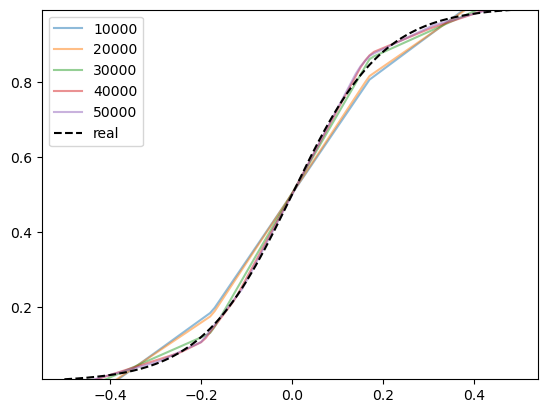

In [21]:
# Определяем функцию нелинейности
relu = lambda x: torch.maximum(x, torch.Tensor([0]))
# Прямой проход
forward = lambda x: (weights_2.t()*relu((weights_1*x) + bias_1)
                      ).sum(axis=-1,keepdims=True) + bias_2
loss = lambda y, y_: ((y-y_)**2).sum(axis=-1)

# # обратный проход
def backward(X, y, y_pred):
    # производная функции потерь по y_pred
    dL = 2*(y_pred-y)
    # значения нейронов скрытого слоя до применения активации
    Ax = (weights_1*X) + bias_1
    # значения нейронов скрытого слоя после применения активации
    A = relu(Ax)
    # производная функции потерь по weight_2
    dW2 = torch.mm(A.t(), dL)
    # производная функции потерь по bias_2
    db2 = dL.sum(axis=0)
    # производная функции потерь по значениям скрытого слоя после активации
    dA = torch.mm(dL, weights_2.t())
    # производная функции потерь по значениям скрытого слоя до активации
    dA[Ax<=0] = 0
    # производная функции потерь по weight_1
    dW = torch.mm(X.t(), dA)
    # производная функции потерь по bias_1
    db = dA.sum(axis=0)
    #print(dW.shape, db.shape, dW2.shape, db2.shape)
    return dW, db, dW2, db2

def optimize(params, grads, lr=0.001):
    # градиентный спуск по всей обучающей выборке
    W1, b1, W2, b2 = params
    W1 -= lr*grads[0]
    W2 -= lr*grads[2]
    b1 -= lr*grads[1]
    b2 -= lr*grads[3]
    return W1, b1, W2, b2

for i in tqdm(range(REGRESSION_EPOCHS)): # 50 тысяч итераций градиентного спуска == 50 тысяч эпох
  output = forward(tensor_X) # обучение
  cur_loss = loss(output, tensor_y) # значение функции потерь на эпохе
  grads = backward(tensor_X, tensor_y, output) # обратное распространение ошибки
  params = [weights_1, bias_1, weights_2, bias_2] 
  weights_1, bias_1, weights_2, bias_2 = optimize(params, grads, 1e-4)
  if (i+1)%10000 == 0:
      plt.plot(X, output.numpy(), label=str(i+1), alpha=0.5)
plt.plot(X, y, linestyle='--', c='k', label='real')
plt.legend()
plt.ylim(y.min(), y.max())
# print
# print(cur_loss.numpy().mean())

# Часть 2. Бинарная классификация с помощью автодиффиренцирования PyTorch

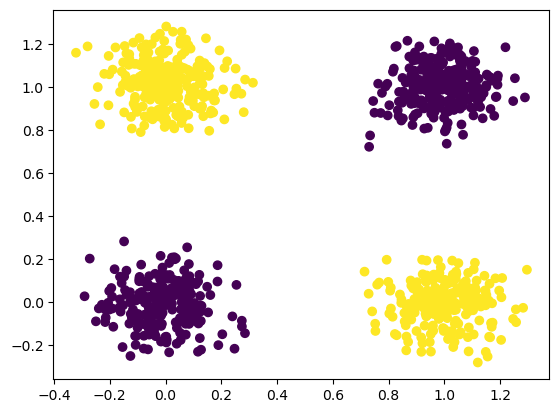

In [22]:
X = np.random.randint(2, size=(1000, 2))

# fig4 = px.line(X)
# fig4.show()

y = (X[:, 0] + X[:, 1]) % 2 # XOR
X = X + np.random.normal(0, scale=0.1, size=X.shape)
#X, y = make_circles(n_samples=1000, noise=0.025)
#X, y = make_moons(n_samples=1000, noise=0.025)


plt.scatter(X[:, 0], X[:, 1], c=y)


####################################################


tensor_X = torch.Tensor(X.reshape(-1, 2))
tensor_y = torch.Tensor(y.reshape(-1, 1))

HIDDEN_SIZE = 16
# Инициализация весов MLP с одним скрытым слоём
weights_1 = ((torch.rand(2, HIDDEN_SIZE)-.5)/10).detach().requires_grad_(True)
bias_1 = torch.zeros(HIDDEN_SIZE, requires_grad=True)

weights_2 = ((torch.rand(HIDDEN_SIZE, 1)-.5)/10).detach().requires_grad_(True)
bias_2 = torch.zeros(1, requires_grad=True)
losses = []


fig5 = px.scatter(X[:, 0],X[:, 1],color=y)
fig5.show()

## Обучение нейронной сети задачи классификации

In [23]:
# Определяем функцию нелинейности
def sigmoid(x):
    return 1/(1+torch.exp(-x))

# Прямой проход
def forward(x):
    hidden = torch.mm(x, weights_1) + bias_1
    hidden_nonlin = sigmoid(hidden)
    output = (weights_2.t()*hidden_nonlin).sum(axis=-1,keepdims=True) + bias_2
    return sigmoid(output)
                       
# Logloss
def loss(y_true, y_pred):
    return -1*(y_true*torch.log(y_pred)+(1-y_true)*torch.log(1-y_pred)).sum()

# задаём шаг обучения
lr = 1e-3
# задаём число итераций
params = [weights_1, bias_1, weights_2, bias_2]
for i in tqdm(range(iters_classification)):
    output = forward(tensor_X)
    lossval = loss(tensor_y, output)
    lossval.backward() # тут включается в работу autograd
    for w in params:
        with torch.no_grad():
            w -= w.grad*lr # обновляем веса
        w.grad.zero_() # зануляем градиенты, чтобы не накапливались за итерации
    losses.append(lossval.item())
# выводим историю функции потерь по итерациям
# plt.plot(losses)

fig6 = px.line(losses)
fig6.show()

  0%|          | 0/50000 [00:00<?, ?it/s]

## Проверка результатов обучения

(-0.4826371099741706, 1.4576532145706884)

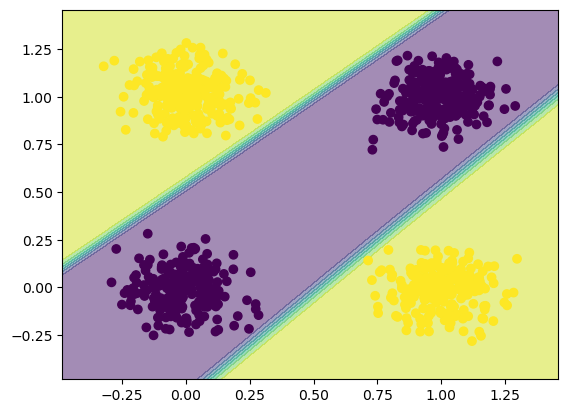

In [24]:
X_diff = X.max() - X.min()
X_left = X.min() - 0.1*X_diff
X_right = X.max() + 0.1*X_diff
grid = np.arange(X_left, X_right, 0.01)
grid_width = grid.size
surface = []
# создаем точки по сетке
for x1 in grid:
    for x2 in grid:
        surface.append((x1, x2))
surface = np.array(surface)
# получаем предсказания для всех точек
with torch.no_grad():
    Z = forward(torch.Tensor(surface)).detach().numpy()
# меняем форму в виде двухмерного массива
Z = Z.reshape(grid_width, grid_width)
xx = surface[:, 0].reshape(grid_width, grid_width)
yy = surface[:, 1].reshape(grid_width, grid_width)
# рисуем разделяющие поверхности классов
plt.contourf(xx, yy, Z, alpha=0.5)
# рисуем обучающую выборку

fig8 = px.scatter(X)
fig8.show()
plt.scatter(X[:, 0], X[:, 1], c=output.detach().numpy()>0.5)
# задаём границы отображения графика
plt.xlim(X_left, X_right)
plt.ylim(X_left, X_right)

# Часть 3. Классификация изображений CIFAR100

## Чтение тренировочной и тестовой выборки

range(0, 1500)
10000


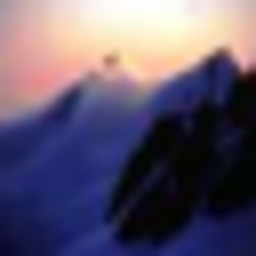

In [25]:
with open(f'{cifar100_path}/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open(f'{cifar100_path}/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

CLASSES = [param_a, param_b, param_c]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCHW -> NHWC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()

print(range(len(train_X)))
train_y = np.unique(train_y, return_inverse=1)[1]



# print(data_train)
# print(np.arange(len(data_train['data'])))
# for a in range(len(data_train['data']))
# print(data_train['data'][3])
# fig10 = px.scatter_3d(x=data_train['data'][0],y=np.arange(3072))
# fig10.show()

del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
print(len(mask))
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[50]).resize((256,256))

## Создание Pytorch DataLoader'a

In [26]:
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = torch.nn.functional.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = torch.utils.data.TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f8ae0f81ff0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f8ae0e0b970>}

In [29]:
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = torch.nn.functional.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = torch.utils.data.TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f8aa12e39d0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f8b0076ea10>}

## Создание Pytorch модели многослойного перцептрона с одним скрытым слоем

In [30]:
class Normalize(torch.nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return torch.flatten(x, start_dim=1) # nhwc -> nm

class Cifar100_MLP(torch.nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_MLP, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025])
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(32*32*3, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, classes),
        )

    def forward(self, input):
        x = self.norm(input)
        return self.seq(x)

model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=3, bias=True)
  )
)

## Выбор функции потерь и оптимизатора градиентного спуска

In [31]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

## Обучение модели по эпохам

In [32]:
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])

table_1 = [] 
table_2= [] 
table_3= [] 
table_4= [] 


for epoch in tqdm(range(EPOCHS)):  # проход по набору данных несколько раз
    running_loss = 0.0
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        running_loss += loss.item()
    # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}')
    table_3.append(f'{running_loss / steps_per_epoch:.3f}')
    # table_1.append(epoch + 1)
    # table_2.append(f'{i + 1:5d}')
    running_loss = 0.0
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    table_1.append(epoch + 1)
    table_2.append(f'{i + 1:5d}')
    table_4.append((f'{running_loss / steps_per_epoch_val:.3f}'))
    # print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
print('Обучение закончено')

  0%|          | 0/100 [00:00<?, ?it/s]

Обучение закончено


In [41]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data

            outputs = model(inputs).detach().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        report = classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES)), output_dict=True)
        print(report[str(param_a)])

train
{'precision': 0.9698189134808853, 'recall': 0.964, 'f1-score': 0.9669007021063191, 'support': 500}
test
{'precision': 0.89, 'recall': 0.89, 'f1-score': 0.89, 'support': 100}


In [ ]:
table = np.array([table_1,table_2,table_3,table_4])
print(table.shape)
table = table.transpose()
print(table.shape)

fig11 = px.scatter(x=range(EPOCHS), y=table_2)
fig11.show()



fig11 = px.scatter(x=range(EPOCHS), y=table_3)
fig11.show()


fig11 = px.scatter(x=range(EPOCHS), y=table_4)
fig11.show()


print(tabulate(table,tablefmt='github',headers=['Эпоха','Номер','loss','val_loss']))

(4, 10000)
(10000, 4)


|   Эпоха |   Номер |   loss |   val_loss |
|---------|---------|--------|------------|
|       1 |       3 |  0.725 |      0.542 |
|       2 |       3 |  0.488 |      0.493 |
|       3 |       3 |  0.407 |      0.415 |
|       4 |       3 |  0.38  |      0.422 |
|       5 |       3 |  0.352 |      0.375 |
|       6 |       3 |  0.337 |      0.388 |
|       7 |       3 |  0.325 |      0.356 |
|       8 |       3 |  0.309 |      0.406 |
|       9 |       3 |  0.304 |      0.332 |
|      10 |       3 |  0.292 |      0.351 |
|      11 |       3 |  0.286 |      0.375 |
|      12 |       3 |  0.278 |      0.332 |
|      13 |       3 |  0.275 |      0.354 |
|      14 |       3 |  0.267 |      0.359 |
|      15 |       3 |  0.261 |      0.396 |
|      16 |       3 |  0.259 |      0.371 |
|      17 |       3 |  0.253 |      0.292 |
|      18 |       3 |  0.25  |      0.383 |
|      19 |       3 |  0.242 |      0.319 |
|      20 |       3 |  0.246 |      0.362 |
|      21 |       3 |  0.239 |  

## Визуализация весов

(10, 3072)


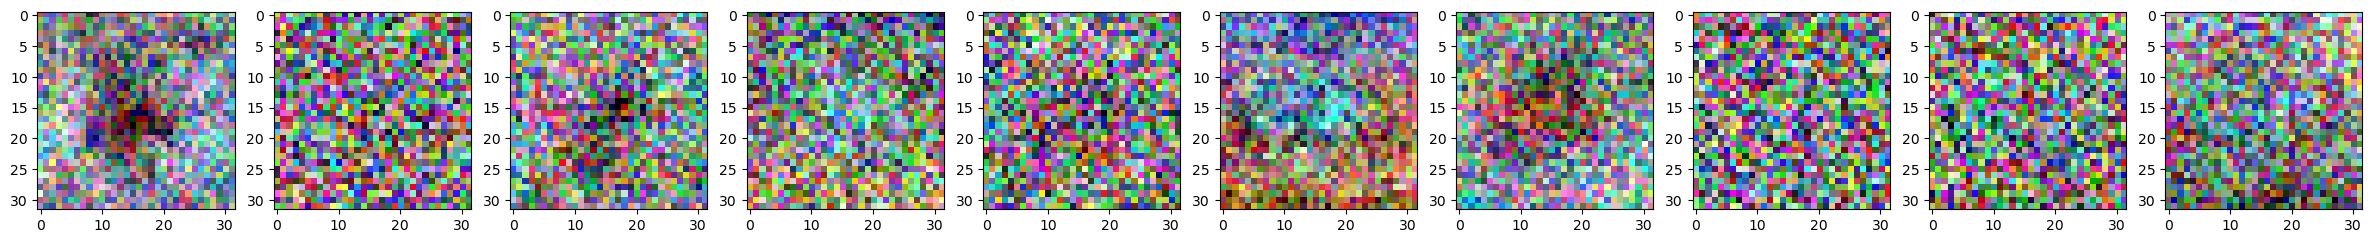

In [ ]:
weights = list(model.parameters())[0].detach().numpy()
print(weights.shape)
fig, ax = plt.subplots(1, weights.shape[0], figsize=(3*weights.shape[0], 3))
for i, ω in enumerate(weights):
    ω = ω.reshape(32, 32, 3)
    ω -= np.percentile(ω, 1, axis=[0, 1])
    ω /= np.percentile(ω, 99, axis=[0, 1])
    ω = np.clip(ω, 0, 1) 
    ax[i].imshow(ω)

# Описание методов библиотек

### Методы и функции NumPy:

(Подробнее в документации https://numpy.org/doc/1.22/reference/index.html)

* __np.array__ - создание массива из списка или другого массива
* __np.shape__ - выводит размерность многомерного массива (т.е. для массива 2х2 будет выведен кортеж (2, 2))
* __np.size__ - выводит число элементов в массиве (т.е. для массива 2х2 будет выведено число 4)
* __np.uint8__, __np.int16__, __np.int64__, __np.float32__ - приведение массива к новому типу, при этом в памяти выделяется место под новый массив выбранного типа. Число после типа обозначет, сколько бит данных используется для хранения одного элемента массива. Для хранения картинок зачастую используется экономный uint8 - беззнаковый 8-битный целочисленный тип данных (диапазон чисел 0-255)
* __np.ones__, __np.zeros__  - создание уже заполненных массивов либо единицами, либо нулями. В качестве аргумента передается список или кортеж с требуемой размерностью. Например `np.ones((10,))` создаст вектор из 10 единичек. А `np.zeros((32, 32, 3))` создаст двузмерный массив разрешением 32 на 32 пикселя с 3 каналами. На практике используется для проверки архитектуры модели в прямом направлении
* __np.arange__ - создание уже заполненного массива в виде возрастающей арифметической прогресии от первого аргумента до второго аргумента не включительно с шагом, который задаётеся третьим аргументом. Первый и третий аргументы можно опускать, в таком случае получается компактная запись `np.arange(3)` => [0, 1, 2]
* __np.repeat__ - дублирование элементов массива на количество, указанное первым аргументом. Таким образом, для массива `arr = [0, 1]` `arr.repeat(2)` вернёт [0, 0, 1, 1]
* __np.exp__ - применение поэлементной операции потенциирования к массиву
* __np.random.normal__ - генерация массива, заполненного случайными нормальными величинами со стандартным отклонением, задающимся через аргумент scale и со средним значением, равным аргументу mean. Число элементов в массиве задаётся числом или списком, переданным аргументу size.
* __np.random.randint__ - генерация массива, заполненного случайными целыми числами в диапазоне, задающимся аналогично __np.arange__. Число элементов в массиве задаётся числом или списком, переданным аргументу size.
* __np.reshape__  - буквально изменение размерности многомерного массива с учётом числа элементов. В качестве аргумента передается многомерный массив, а также список или кортеж с новой размерностью. Например `np.reshape([0, 1, 2, 3], (2,2))` создаст двухмерный массив размером 2х2. При этом в памяти новый массив не выделяется, а меняется лишь способ обхода по нему. Разрешается также и следующий способ вызова метода: `arr.reshape(2, 2)`. Обратите внимание на отсутствие дополнительных скобок. Если вместо конкретного числа подставить -1, то размерность будет подсчитана автоматически. На практике используется для выпрямление картинок в виде одномерного массива: `X.reshape(-1, 3072)`# [100, 32, 32, 3] -> [100, 3072]
* __np.transpose__  - переименование осей многомерного массива. Для работы с изображениями принято два формата NHWC и NCHW (N - число картинок в массиве, C - число каналов, H - высота, W - ширина). В качестве аргумента передается многомерный массив, а также список или кортеж с новой расстановкой осей. Например `np.transpose([[0, 1, 2, 3]], (1,0))` создаст двухмерный вектор-столбец [[[0], [1], [2], [3]]. Заметьте, что отсчет осей начинается с 0. На практике используется для перевода NHWC в NCHW и обратно. В первом случае 0 ось N остаётся на своём первом месте, первая и вторая оси H и W сдвигаются на одну позицию вправо, а 3 ось - C ставится на второе место. Т.е. получим следующую перестановку: [0, 3, 1, 2] 
* __np.isin__ - аналог SQL оператора IN, поэлементная проверка вхождения массива в коллекцию. `np.isin([0, 2, 1], [2, 3])` вернёт [False, True, False]
* __индексирование__ - выбор подмассива или среза массива осуществляется с помощью квадратных скобок []. Если `arr = np.array([2, 1, 0])`, то `arr[0]` вернёт первый элемент. `arr[[0, 1]]` - обращение по индексу, `arr[[True, False, True]]` - обращение по булевой маске. Заметьте, что обращение по индексу необязательно должно совпадать с размерностью массива, в отличие от обращения по маске. На практике удобно записывать значения маски в отдельную переменную. Для выбора конкретного столбца в многомерном массиве используется синтаксис срезов [:, k], где k - номер столбца. Если k равняется -1, то используется последний столбец или элемент. Так, например, для массива `arr = np.array([[0, 1], [2, 3], [4, 5])` выражение `arr[:, 0]` вернет массив [0, 2, 4]. Поскольку используется индекс срезов (стандартный синтаксис Python), то можно также выполнять срезы многомерных массивов. Для предыдущего примера `arr[1:2, 0:1]` вернёт [[2]]
* __np.unique__ - аналог SELECT DISTINCT в SQL. При стандартных параметрах возвращает одномерный подмассив, содержащий уникальные элементы. Если указать выставить флаг __return_inverse__, то вернется массив с номерами отсчётов массива с уникальными элементами. По сути выполняется Label Encoding
* __np.concatenate__ - конкатенация многомерного массива вдоль указанной оси. Номер оси указывается через аргумент __axis__. Например может быть использован для объединения нескольких признаков или нескольких наборов данных. В контексте изображений может использоваться для объединения или склейки нескольких изображений в одно как вертикально, так и горизонтально. В контексте звука - склеивание двух аудиодорожек.
* __np.max__, __np.min__ - возвращает максимальный и минимальный элементы массива вдоль указанной оси, соответственно. Если номер оси не указан, то возвращается число. Номер оси указывается через аргумент __axis__. Если указывается -1, то полагается, что используется последний номер оси. Разрешается также и вызов функции в качестве метода многомерного массива: `arr.max()`
* __np.argmax__ - возвращает индекс максимального элемента массива вдоль указанной оси. Если номер оси не указан, то возвращается первый индекс, соответвующих максимальному значению в массиве, т.е. одно число. Номер оси указывается через аргумент __axis__. Если указывается -1, то полагается, что используется последний номер оси. На практике используется для расчёта метрики доли правильных ответов модели (Accuracy). Разрешается также и вызов функции в качестве метода многомерного массива: `arr.argmax(axis=-1)`

### Методы и функции Pickle
(Документация: https://docs.python.org/3/library/pickle.html)

* __pickle.dump__ - сериализация структуры данных Python. Первым аргументом идёт сама структура, а вторым FileObject. При этом FileObject должен быть открыт в режиме записи байт (wb). Можно указать кодировку байт (big endian/ little endian). Тем самым можно хранить на постоянном носителе стандартные структуры данных, в том числе NumPy массивы.
* __pickle.load__ - десериализация структуры данных Python. Первым аргументом идёт FileObject. При этом FileObject должен быть открыт в режиме чтения байт (rb). Можно указать кодировку байт (big endian/ little endian). Тем самым можно загружать ранее сохранённые структуры данных, что может быть полезно, если для их создания требуется длительное время (например, параметры модели глубокого обучения)


### Методы и функции Sklearn
(Документация: https://scikit-learn.org/stable/modules/classes.html)

* __datasets.make_circles__, __datasets.make_moons__ - генерация синтетической обучающей выборки для задачи классификации, возвращает X - двухмерный массив с числом примеров и числом признаков (признаков 2), а также одномерный массив с метками классов (0 или 1)

* __metrics.classification_report__ - cоздает текстовый отчет, показывающий основные метрики классификации (доля правильных ответов, полнота, точность, f1-мера). В качестве первого аргумента передаются истинные метки класса, в качестве второго - метки класса, предсказанные моделью. Дополнительные полезные аргументы: digits - число выводимых знаков после запятой (по умолчанию 2), output_dict - возвращает словарь с расчитанными метриками вместо строки, sample_weight - расчитывает взвешенные метрики на основе веса каждого примера

* __metrics.confusion_matrix__ - вычисляет матрицу ошибок модели для оценки точности классификации. Матрица ошибок идеальной модели имеет значения только на главной диагонали. Может быть использована для подсчёта всех классических метрик классификации (доля правильных ответов, полнота, точность, специфичность, f1-мера).

### Методы и функции PIL

(Документация: https://pillow.readthedocs.io/en/stable/)

* __Image.fromarray__ - cоздает объект Image на основе двухмерного массива или двухмерного массива с каналами. Часто ругается, если тип данных не uint8. Часто ругается, если производится попытка создать черно-белое изображения из картинки размерностью (W, H, 1). Для того, чтобы получить обратно массив из объекта Image, достаточно привести его к NumPy массиву, например np.array(img)

* __Image.resize__ - меняет разрешение изображения с помощью интерполяции. Первым аргументом указывается список с новой шириной и высотой изображения. При желании можно указать тип интерполяции через аргумент resample. Поддерживаемые значения: PIL.Image.NEAREST, PIL.Image.BOX, PIL.Image.BILINEAR, PIL.Image.HAMMING, PIL.Image.BICUBIC, PIL.Image.LANCZOS. По умолчанию используется бикубическая интерполяция.

* __Image.convert__ - переводит изображение из одной цветовой схемы в другую. Новая цветовая схема передается строкой, L - черно белая, LA - черно-белая с прозрачностью, RGB - стандартная цветовая схема с 3 каналами, RGBA - стандартная цветовая схема с 3 каналами цвета и одним каналом прозрачности, HSV - альтернативное цветовое представление и т.д.

* __Image.open__ - считывает изображение по указанному пути в виде строки или FileObject. При создании набора данных может неправильно определить формат (например L вместо RGB), поэтому рекомендуется сразу после open приводить к нужному формату при помощи метода convert

* __Image.save__ - сохраняет изображение по указанному пути в виде строки или FileObject. Если указывается FileObject, то нужно также указать формат изображения в аргументе format, например 'PNG' или 'JPEG'

### Методы и функции Matplotlib

(Документация: https://matplotlib.org/stable/api/index.html)

Принятые сокращения:
* matplotlib.pyplot - plt

Методы:
* __plt.plot__ - рисует график по точкам и соединяет их линией. Первым аргументом передаются x-координаты, вторым - у-координаты. Если не передавать второй аргумент, х координаты будут приняты за у, а в качестве х будут использованы отсчёты массива. Дополнительные полезные аргументы: linestyle - тип отображаемой линиии ('--', '-', '-.' и т.д.), color - цвет линии ('k' - черный, 'r' - красный, 'white' - белый и т.д.), alpha - прозрачность линии, число от 0 (линия не видна) до 1 (нет прозрачности), label - текстовая метка данного графика.
* __plt.scatter__ - рисует график по точкам юез соединения линиями. Первым аргументом передаются x-координаты, вторым - у-координаты. Если не передавать второй аргумент, х координаты будут приняты за у, а в качестве х будут использованы отсчёты массива. Дополнительные полезные аргументы: s - размер точек, color - цвет точек ('k' - черный, 'r' - красный, 'white' - белый и т.д.), alpha - прозрачность точек, число от 0 (линия не видна) до 1 (нет прозрачности), label - текстовая метка данного графика.
* __plt.contourf__ - рисует заполненные контурные линии, разграничивающие границы.
* __plt.show__ - принудительная отрисовка графика, может использоваться для вывода нескольких графиков в одном блоке кода.
* __plt.legend__ - отображает ранее указанные метки графиков
* __plt.xlim__ - ограничивает диапазон x-координат от первого до второго аргумента. По умолчанию диапазон горизонтальной оси подбирается автоматически на основе используемых данных. Для задания диапозана значений горизонтальной оси вручную и используется данный метод
* __plt.ylim__ - аналогично __plt.xlim__, но для вертикальнйо оси.



